# Exploring Quantile Regression as Classification

The purpose of this notebook is to explore the possibility to fit conditiona
quantile estimators using classifiers on binned target values with
interpolation at predict-time.

In [65]:
from scipy.interpolate import interp1d
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.validation import check_consistent_length
from sklearn.utils import check_random_state
import numpy as np


class BinnedQuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self,
            estimator=None,
            n_bins=100,
            quantile=0.5,
            binning_strategy="quantile",
            interpolation_knots="midpoints",
            interpolation_kind="linear",
            random_state=None,
        ):
        self.n_bins = n_bins
        self.estimator = estimator
        self.quantile = quantile
        self.binning_strategy = binning_strategy
        self.interpolation_knots = interpolation_knots
        self.interpolation_kind = interpolation_kind
        self.random_state = random_state

    def fit(self, X, y):
        assert self.interpolation_knots in ("edges", "midpoints")
        # Lightweight input validation: most of the input validation will be
        # handled by the sub estimators.
        random_state = check_random_state(self.random_state)
        check_consistent_length(X, y)
        self.target_binner_ = KBinsDiscretizer(
            n_bins=self.n_bins,
            strategy=self.binning_strategy,
            subsample=200_000,
            encode="ordinal",
            random_state=random_state,
        )

        y_binned = self.target_binner_.fit_transform(
            np.asarray(y).reshape(-1, 1)
        ).ravel().astype(np.int32)

        # Fit the multiclass classifier to predict the binned targets from the
        # training set.
        if self.estimator is None:
            estimator = RandomForestClassifier(random_state=random_state)
        else:
            estimator = clone(self.estimator)
        self.estimator_ = estimator.fit(X, y_binned)
        return self

    def predict_quantiles(self, X, quantiles):
        check_is_fitted(self, "estimator_")
        edges = self.target_binner_.bin_edges_[0]
        n_bins = edges.shape[0] - 1
        expected_shape = (X.shape[0], n_bins)
        y_proba_raw = self.estimator_.predict_proba(X)
        
        # Some might stay empty on the training set, in particular with the
        # uniform binning strategy. Typically, classifiers do not learn to
        # predict an explicit 0 probability for unobserved classes so we have
        # to post process their output:
        if y_proba_raw.shape != expected_shape:
            y_proba = np.zeros(shape=expected_shape)
            y_proba[:, self.estimator_.classes_] = y_proba_raw
        else:
            y_proba = y_proba_raw

        # Build the mapper for inverse CDF mapping, from cumulated
        # probabilities to continuous prediction.
        if self.interpolation_knots == "edges":
            y_cdf = np.zeros(shape=(X.shape[0], edges.shape[0]))
            y_cdf[:, 1:] = np.cumsum(y_proba, axis=1)
            return np.asarray(
                [
                    interp1d(
                        y_cdf_i,
                        edges,
                        kind=self.interpolation_kind,
                    )(quantiles)
                    for y_cdf_i in y_cdf
                ]
            )
        else:
            midpoints = (edges[1:] + edges[:-1]) / 2
            y_cdf = np.cumsum(y_proba, axis=1)
            return np.asarray(
                [
                    interp1d(
                        y_cdf_i,
                        midpoints,
                        kind=self.interpolation_kind,
                        bounds_error=False,
                        fill_value=(midpoints[0], midpoints[-1]),
                    )(quantiles)
                    for y_cdf_i in y_cdf
                ]
            )

    def predict(self, X):
        return self.predict_quantiles(X, self.quantile).ravel()

Let's define a toy 1D dataset with heteroscedastic noise to compare different base classifiers:

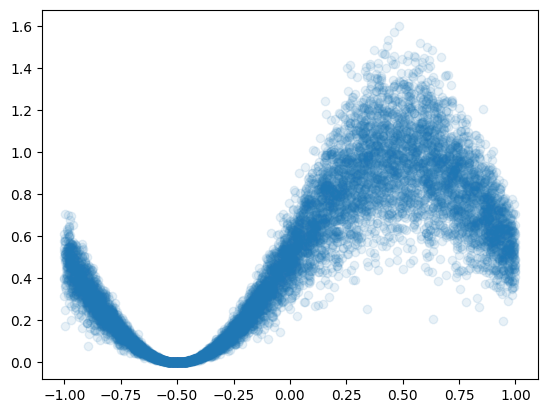

In [66]:
import matplotlib.pyplot as plt
from functools import partial

rng = np.random.RandomState(42)
x = rng.uniform(-1, 1, size=10_000)
X = x.reshape(-1, 1)
y = np.sin(x * np.pi) + 1
y /= y.max()

# Add heteroscedastic noise to make conditional quantiles interesting:
y += rng.normal(0, y / 5, size=y.shape)
_ = plt.plot(x, y, "o", alpha=0.1)

Let's also define some reusable helper functions to compare the models:

In [67]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

def fit_and_plot(model, X, y, display_bin_edges=False):
    _ = plt.plot(X.ravel(), y, "o", alpha=0.1, markeredgewidth=0)
    X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    q_pred = model.fit(X, y).predict(X_test)
    plt.plot(X_test, q_pred, label="q=0.95")
    if display_bin_edges:
        # Plot horizontal lines for each of the bin edges:
        bin_edges = model.target_binner_.bin_edges_[0]
        plt.hlines(
            bin_edges,
            X_test.min(),
            X_test.max(),
            color="k",
            linestyles="-",
            linewidths=0.2,
            alpha=0.2,
        )
    plt.legend()
    plt.show()


def evaluate(model, X, y, quantile=0.95):
    neg_q95_pinball_loss = make_scorer(
        partial(mean_pinball_loss, alpha=0.95),
        greater_is_better=False,
    )
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=5,
        scoring=neg_q95_pinball_loss,
        return_train_score=True,
        n_jobs=-1,
    )
    train_scores = -cv_results["train_score"]
    val_scores = -cv_results["test_score"]
    fit_time = cv_results["fit_time"]
    print(
        f"Train pinball (q={quantile:.2f}): {train_scores.mean():.4f} +/- {train_scores.std():.4f}\n"
        f"Val pinball (q={quantile:.2f}): {val_scores.mean():.4f} +/- {val_scores.std():.4f}\n"
        f"Fit time: {fit_time.mean():.4f} +/- {fit_time.std():.4f} s"
    )

## RandomForestClassifier and the impact of the number of target bins

This classifier can naturally handle a large number of classes (target value bins). It's a strong baseline as it is fast to fit and yields strong pinball loss values.

Let's use it to explore the impact of the number of bins.

Train pinball (q=0.95): 0.0112 +/- 0.0001
Val pinball (q=0.95): 0.0115 +/- 0.0003
Fit time: 0.1737 +/- 0.0137 s


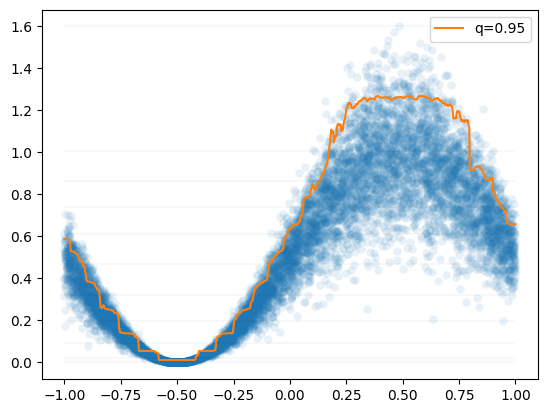

In [68]:
base_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=30,
    min_samples_leaf=50,
    n_jobs=-1,
)
binned_quantile_reg = BinnedQuantileRegressor(
    estimator=base_classifier,
    n_bins=10,  # small value!
    quantile=0.95,
    random_state=42,
)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=True)

Note that the interpolation makes it possible to predict values between
the midpoints of the bins. This is not possible with the classifier alone.
However we can see steps, so the model is probably underfitting because of
the small number of bins. Let's increase it:

Train pinball (q=0.95): 0.0098 +/- 0.0000
Val pinball (q=0.95): 0.0103 +/- 0.0001
Fit time: 0.1910 +/- 0.0163 s


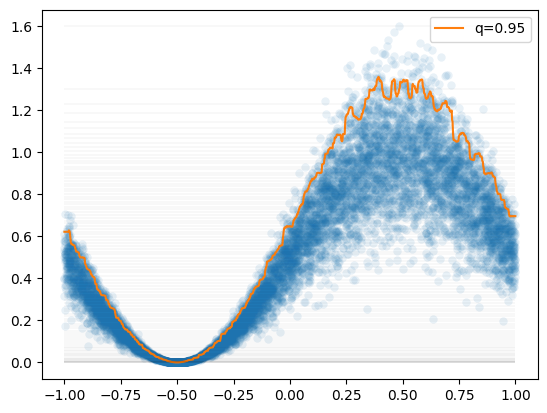

In [69]:
binned_quantile_reg.set_params(n_bins=100)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=True)

We can increase it a lot more. Note that the resulting model is slower but
not overfitting more than the previous one:

Train pinball (q=0.95): 0.0098 +/- 0.0000
Val pinball (q=0.95): 0.0103 +/- 0.0001
Fit time: 0.4684 +/- 0.0524 s


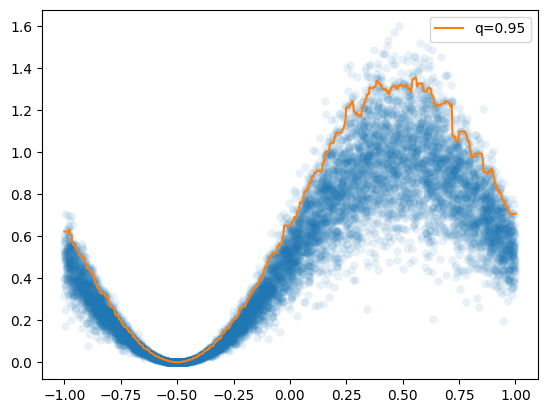

In [70]:
binned_quantile_reg.set_params(n_bins=1000)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=False)

For the rest of the notebook, we will keep the number of bins to 100:

In [71]:
n_bins = 100
_ = binned_quantile_reg.set_params(n_bins=n_bins)

## MLPClassifier on spline numerical features

Much slower (100x) on CPU but better slightly better results. This is the
only method that yields a smooth (and non-oscillating) prediction function:

/data/parietal/store3/work/ogrisel/mambaforge/envs/retreat/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/parietal/store3/work/ogrisel/mambaforge/envs/retreat/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/parietal/store3/work/ogrisel/mambaforge/envs/retreat/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/parietal/store3/work/ogrisel/mambaforge/envs/retreat/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

Train pinball (q=0.95): 0.0101 +/- 0.0000
Val pinball (q=0.95): 0.0102 +/- 0.0001
Fit time: 12.6732 +/- 0.3640 s


/data/parietal/store3/work/ogrisel/mambaforge/envs/retreat/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


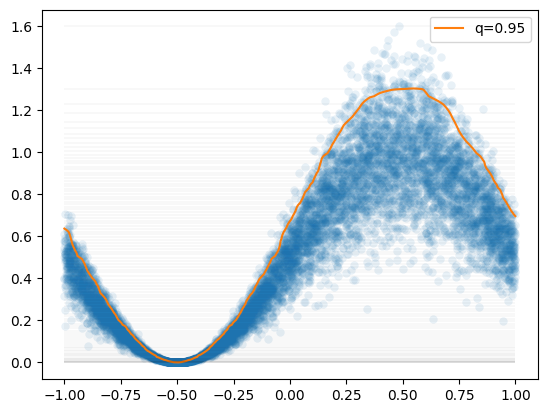

In [77]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer


base_classifier = make_pipeline(
    SplineTransformer(n_knots=5, degree=3),
    MLPClassifier(
        random_state=42,
        hidden_layer_sizes=[100, 100],
        solver="adam",
        max_iter=100,
    ),
)
binned_quantile_reg.set_params(estimator=base_classifier)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=True)

## XGBClassifier with vector leafs

Using the XGBoost classifier as a base estimator gives good enough results
but it typically slower and not better than RF with tuned `min_samples_leaf`.

The story might be different on datasets with a very large number of samples.

Probably requires more expensive hyperparameter tuning to shine.

Train pinball (q=0.95): 0.0100 +/- 0.0000
Val pinball (q=0.95): 0.0103 +/- 0.0001
Fit time: 5.5761 +/- 0.1180 s


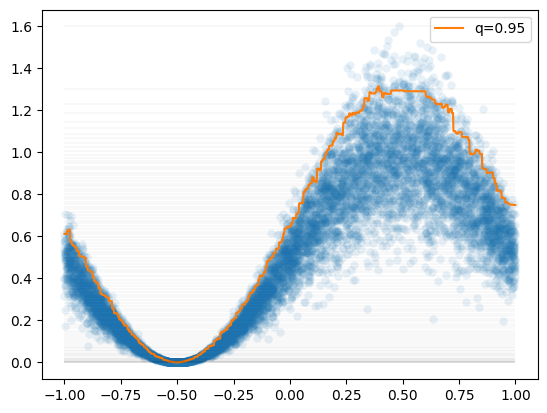

In [73]:
from sympy import N
from xgboost import XGBClassifier

base_classifier = XGBClassifier(
    tree_method="hist",
    multi_strategy="multi_output_tree",
    random_state=42,
    max_leaves=10,
    n_estimators=100,
    learning_rate=0.3,
)
binned_quantile_reg.set_params(estimator=base_classifier)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=True)

## HistGradientBoostingClassifier

There is a problem with this one. It does not work at all I have not find the cause yet, even when tweaking the hparams:

Train pinball (q=0.95): 0.0166 +/- 0.0014
Val pinball (q=0.95): 0.0176 +/- 0.0022
Fit time: 0.5303 +/- 0.0179 s


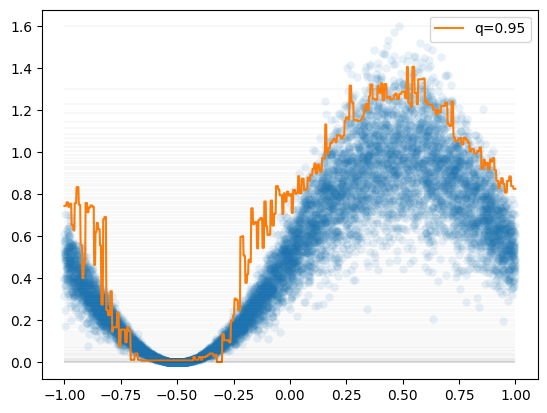

In [74]:
from sklearn.ensemble import HistGradientBoostingClassifier

base_classifier = HistGradientBoostingClassifier(
    random_state=42,
    max_leaf_nodes=10,
    early_stopping=True,
    n_iter_no_change=3,
    max_iter=1_000,
    learning_rate=0.3,
)
binned_quantile_reg.set_params(estimator=base_classifier)
evaluate(binned_quantile_reg, X, y)
fit_and_plot(binned_quantile_reg, X, y, display_bin_edges=True)

## Comparing to traditional quantile regressor

Train pinball (q=0.95): 0.0097 +/- 0.0000
Val pinball (q=0.95): 0.0103 +/- 0.0002
Fit time: 0.1239 +/- 0.0070 s


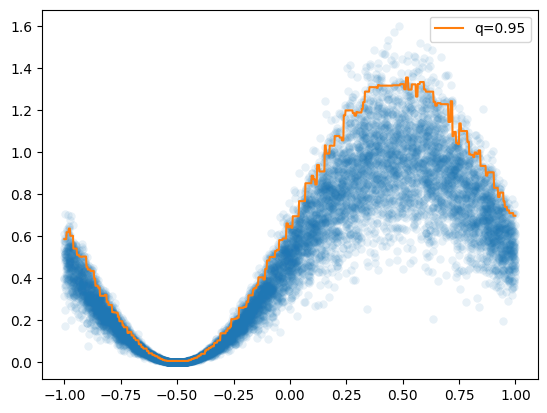

In [75]:
from sklearn.ensemble import HistGradientBoostingRegressor


quantile_regressor = HistGradientBoostingRegressor(
    random_state=42,
    loss="quantile",
    quantile=0.95,
    max_leaf_nodes=10,
    early_stopping=True,
    n_iter_no_change=3,
    max_iter=1_000,
    learning_rate=0.3,
)
evaluate(quantile_regressor, X, y)
fit_and_plot(quantile_regressor, X, y)

Train pinball (q=0.95): 0.0097 +/- 0.0001
Val pinball (q=0.95): 0.0103 +/- 0.0001
Fit time: 0.2016 +/- 0.0005 s


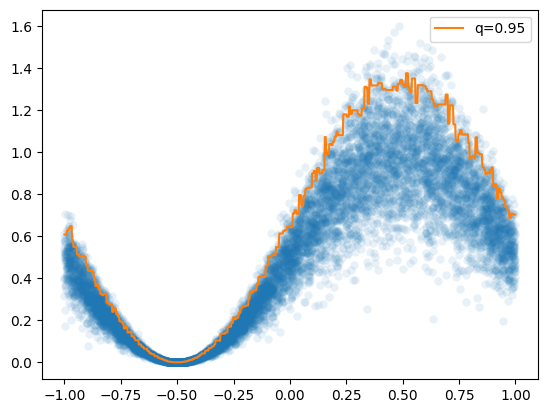

In [76]:
from xgboost import XGBRegressor

quantile_regressor = XGBRegressor(
    random_state=42,
    tree_method="hist",
    objective="reg:quantileerror",
    quantile_alpha=0.95,
    max_leaves=10,
    n_estimators=100,
    learning_rate=0.3,
)
evaluate(quantile_regressor, X, y)
fit_and_plot(quantile_regressor, X, y)